# Вспомогательный код

In [ ]:
def exponential_smoothing(scalars, weight):
    last = scalars[0]
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


class HistoryPlotter:
    def __init__(self):
        # dict for safe learning history
        self._history_dict = {}

    def add(self, history):
        """
        Save learning history.
        history: dict with keys: model_name, epoсhs, loss_on_train, loss_on_test
        """
        self._history_dict[history["model_name"]] = history
        self.color_list = list(mcolors.TABLEAU_COLORS.keys())

    def plot(self, models, show_smooth=True, smooth_val=0.90):
        """
        Plot informatiom from self._history_dict.
        models: list of model_name (len <= 5, or extend color_list)
        """
        fig, ax = plt.subplots(3, 1, figsize=(10, 10))
        for model_num, model_name in enumerate(models):
            history = self._history_dict[model_name]
            for idx, (key, title) in enumerate(
                zip(["loss_on_train", "loss_on_test"], ["train loss", "test loss"])
            ):
                epoch_len = len(history[key]) // history["epoсhs"]
                loss_len = len(history[key])
                ticks_positions = np.arange(history["epoсhs"] + 1)

                if show_smooth:
                    x = np.arange(len(history[key])) / epoch_len
                    # Plot train loss and test loss:
                    # 1. plot smoothing vals
                    ax[idx].plot(
                        x,
                        exponential_smoothing(history[key], smooth_val),
                        label=model_name + " smoothed",
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 2. plot raw vals
                    ax[idx].plot(
                        x,
                        history[key],
                        label=model_name + " raw",
                        alpha=0.2,
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 3. add descriptions if it is nesessary
                    if not ax[idx].title.get_text():
                        ax[idx].set_title(title)
                        ax[idx].set_xlabel("epochs")
                        ax[idx].set_ylabel("loss")
                        ax[idx].set_xticks(ticks_positions)
                        ax[idx].set_xticklabels(np.arange(history["epoсhs"] + 1))
                    ax[idx].legend()

                # Plot mean train and test loss combined:
                # 1. calculate mean and std
                mean_loss_on_epoch = [
                    np.mean(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                std_loss_on_epoch = [
                    np.std(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                # 2. plot
                ax[2].errorbar(
                    np.arange(history["epoсhs"]) + idx / 30.0,
                    mean_loss_on_epoch,
                    yerr=std_loss_on_epoch,
                    capsize=5,
                    fmt="X--",
                    label=model_name + " " + title,
                )
                # 3. add descriptions if it is necessary
                if not ax[2].title.get_text():
                    ax[2].set_title("\nAverage loss per epoch", {"fontsize": 12})
                    ax[2].set_xticks(np.arange(history["epoсhs"]))
                    ax[2].set_xticklabels(np.arange(history["epoсhs"]))
                    ax[2].set_xlabel("epochs")
                    ax[2].set_ylabel("loss")
                ax[2].legend()
        plt.subplots_adjust(hspace=0.4)
        plt.show()

In [ ]:
history_plotter = HistoryPlotter()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

# transforms for data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.13), (0.3))]
)

data_set = MNIST(root="./MNIST", train=True, download=True, transform=transform)
train_set, val_set = random_split(
    data_set, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)
test_set = MNIST(root="./MNIST", train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()
print("Already downloaded!")

Already downloaded!


In [ ]:
import torch.nn as nn

class SimpleMNIST_NN_Batchnorm(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        self.n_layers = n_layers
        layers = [
            nn.Linear(28 * 28, 100, bias=False),
            nn.BatchNorm1d(100),
            nn.Sigmoid(),
        ]
        for _ in range(0, n_layers - 1):
            layers.append(nn.Linear(100, 100, bias=False))
            layers.append(nn.BatchNorm1d(100))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(100, 10))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layers(x)
        return x

In [ ]:
!pip install -q lightning tbparse
clear_output()

In [ ]:
import torch
import lightning as L


class Pipeline(L.LightningModule):
    def __init__(
        self,
        model,
        exp_name="baseline",
        criterion=nn.CrossEntropyLoss(),
        optimizer_class=torch.optim.SGD,
        optimizer_kwargs={"lr": 0.001},
    ) -> None:
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

        # Additionally, we will save training logs “manually”
        # for visualization within the lecture. Please limit yourself
        # to the native training logging tools from PytorchLightning
        # when training your own models.
        self.history = {"loss_on_train": [], "loss_on_test": [], "model_name": exp_name}

    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_train", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_train"].append(loss.cpu().detach().item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_test", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_test"].append(loss.cpu().detach().item())

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger

model_name = "batchnorm_increased_lr"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name, optimizer_kwargs={"lr": 1e-2})

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# Оптимизация параметров нейросетей

В процессе обучения мы пытаемся подобрать параметры модели, при которых она будет работать лучше всего. Это — **оптимизационная задача** (задача подбора оптимальных параметров). Мы уже ознакомились с одним алгоритмом оптимизации параметров — **градиентным спуском**.

Существует множество **алгоритмов оптимизации**, которые можно применять для поиска минимума функционала ошибки ([неполный список 🎓[article]](https://paperswithcode.com/methods/category/stochastic-optimization)). Эти алгоритмы реализованы в модуле `torch.optim` [🛠️[doc]](https://pytorch.org/docs/stable/optim.html).

Важно отметить, что **выбор оптимизатора не влияет на расчет градиента**. Градиент в PyTorch вычисляется автоматически на основе графа вычислений.


## Обзор популярных оптимизаторов

### SGD (stochastic gradient descent)

При градиентном спуске мы:
- делаем **прямой проход**, вычисляем функционал ошибки $\large L(x, y, w_t)$;
- делаем **обратный проход**, вычисляем градиент $\large \nabla_wL(x, y, w_t)$;
- делаем **шаг оптимизации**: изменяем параметры модели по формуле:

$$\large w_{t+1} = w_t - \text{lr} \cdot \nabla_wL(x, y, w_t),$$

домножая антиградиент на постоянный коэффициент $\text{lr}$ (гиперпараметр обучения — learning rate).

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/stochastic_gradient_descent.gif" width="950">

У данного алгоритма есть проблема: он может застревать в **локальных минимумах** или даже **седловых точках**.

**Cедловые точки** — точки, в которых все производные равны $0$, но они не являются экстремумами. В них градиент равен $0$, веса не обновляются — оптимизация останавливается.

Пример таких точек:

- точка $(0, 0)$ у функции $y = x^3$, не имеющей минимума или максимума вовсе;
- точка $(0, 0, 0)$ у функции $z = x^2 - y^2$.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/getting_stuck_in_local_minimum_example.png" width="350"> <img src ="https://ml.gan4x4.ru/msu/dep-2.1/L07/saddle_point_example.png" width="400"></center>

<center><em>Source: <a href="https://ru.wikipedia.org/wiki/%D0%A1%D0%B5%D0%B4%D0%BB%D0%BE%D0%B2%D0%B0%D1%8F_%D1%82%D0%BE%D1%87%D0%BA%D0%B0">Седловая точка</a></em></center>

Частично эту проблему решает **стохастический градиентный спуск** (stochastic gradient descent, **SGD**). В нем для градиентного спуска используются не все данные, а некоторая подвыборка (mini-batch) или даже один элемент.


**SGD** обладает важной особенностью: на каждом объекте или подвыборке (mini-batch) ландшафт функции потерь выглядит по-разному. Некоторые минимумы функции потерь и седловые точки могут быть характерны лишь для части объектов.

Ниже **упрощенно** показаны ландшафты функции потерь на полном датасете и на отдельных батчах. При оптимизации на полном датасете модель могла бы **остановиться в левом локальном минимуме**, но стохастическая природа спуска позволяет избежать этого за счет того, что **для некоторых батчей этот минимум отсутствует**.

В результате модель сможет остановиться только в каком-то относительно широком и глубоком минимуме, характерном для большинства батчей обучающих данных. С большой вероятностью этот минимум будет присутствовать и на реальных данных, то есть модель сможет адекватно работать с ними.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/sgd_loss_batch_landscape.png" width="700"></center>

**SGD** до сих пор является достаточно популярным методом обучения нейросетей, потому что он простой, не требует подбора дополнительных гиперпараметров, кроме **скорости обучения** `lr`, и сам по себе обычно дает неплохие результаты.

Если же модель учится слишком долго и/или важна каждая сотая в качестве, то нужно либо использовать его в совокупности с другими техниками (их рассмотрим далее), либо использовать другие способы.

Фрагмент кода для понимания работы SGD:
```python
class SGD:
  def __init__(self, parameters, lr):
    self.parameters = parameters
    self.lr = lr

  def step(self):
    d_parameters = self.parameters.grad
    self.parameters -= self.lr*d_parameters
```

Алгоритм SGD реализован в `torch.optim.SGD` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html):

In [ ]:
import torch.optim as optim

parameters = torch.randn(10, requires_grad=True)
optimizer = optim.SGD(model.parameters(), lr=0.001)

**Минусы SGD**:

 1. Если функция ошибки в одном направлении меняется быстро, а в другом — медленно, то это приводит к резким изменениям направления градиентов и замедляет процесс обучения.


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/stohastic_gradient_descent_no_momentum.gif" width="500"></center>


 2. Может застревать в локальных минимумах или седловых точках.

 3. Мы оцениваем градиент по малым частям выборки, которые могут плохо отображать градиент по всей выборке и являться шумными. В результате часть шагов градиентного спуска делается впустую или во вред.

 4. Мы применяем один и тот же `learning rate` ко всем параметрам, что не всегда разумно. Параметр, отвечающий редкому классу, будет обучаться медленнее остальных.

 5. Просто медленнее сходится.

**SGD** является основой всех описанных ниже алгоритмов.

### Momentum

Чтобы избежать проблем 1–3, можно добавить движению по ландшафту функции ошибок инерцию (**momentum**). По аналогии с реальной жизнью: если мяч катится с горки, то он благодаря инерции может проскочить пологое место или даже небольшую яму.

Корректируем направление движения шарика с учетом текущего градиента:

$$\large v_{t} = m \cdot v_{t-1} + \nabla_wL(x, y, w_{t}),$$

где $m \in [0, 1)$ — momentum (гиперпараметр).

Вычисляем, куда он покатится:

$$\large w_{t+1} = w_t - lr \cdot v_{t}$$

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/advantages_wtih_momentum.png" width="480"></center>

[[video] 📺 Градиентный спуск, как обучаются нейронные сети](https://youtu.be/IHZwWFHWa-w)

Теперь мы быстрее достигаем локального минимума и можем выкатываться из совсем неглубоких. Градиент стал менее подвержен шуму, меньше осциллирует

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/stohastic_gradient_descent_no_momentum.gif" width="500"> <img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/stohastic_gradient_descent_with_momentum.gif" width="500">

Фрагмент кода для понимания работы Momentum:

```python
class SGD_with_momentum:
  def __init__(self, parameters, momentum, lr):
    self.parameters = parameters
    self.momentum = momentum
    self.lr = lr
    self.velocity = torch.zeros_like(parameters)

  def step(self):
    d_parameters = self.parameters.grad
    self.velocity =  self.momentum*self.velocity + d_parameters
    self.weights -= self.lr*self.velocity
```


**Momentum удваивает количество хранимых параметров.**

Алгоритм Momentum реализован в `torch.optim.SGD` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html):

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.001)

У этого подхода есть одна опасность — мы можем выкатиться за пределы минимума, к которому стремимся, а потом какое-то время к нему возвращаться.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/problem_of_big_momentum_value.gif" width="700">

<em>Source: <a href="https://distill.pub/2017/momentum/">Why Momentum Really Works</a></em></center>

[[demo] 🎮 Why Momentum Really Works](https://distill.pub/2017/momentum/)

Чтобы с этим бороться, предложен другой способ подсчета инерции.

### NAG (Nesterov momentum)

Будем сначала смещаться в сторону, куда привел бы нас накопленный градиент, там считать новый градиент и смещаться по нему.
В результате перескоки через минимум будут менее значительными и алгоритм будет быстрее сходиться:

$$\large v_{t} = m \cdot v_{t-1} +  \nabla_w L(w_t - \text{lr} \cdot m \cdot  v_{t-1} )$$

$$\large w_{t+1} = w_{t} - \text{lr} \cdot v_{t} $$

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/nesterov_momentum.png" width="800"></center>

Кажется, что для реализации такого алгоритма необходимо пересчитывать прямой и обратный проход с новыми параметрами для вычисления градиента. На практике эту формулу можно [переписать 🎓[article]](http://www.cs.toronto.edu/~hinton/absps/momentum.pdf) так, чтобы не пересчитывать градиент.

С псевдокодом, описывающим последовательность действий NAG, можно познакомиться в [PyTorch 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html).

**Так же, как momentum, Nesterov momentum удваивает количество хранимых параметров.**

Алгоритм Nesterov momentum реализован в `torch.optim.SGD` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html):

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.SGD(model.parameters(), momentum=0.9, nesterov=True, lr=0.001)

### Adaptive Learning Rate

Описанные алгоритмы не борются с 4-ой проблемой SGD: "мы применяем **один и тот же learning rate ко всем параметрам**, что не всегда разумно. Параметр, отвечающий редкому классу, будет обучаться медленнее остальных".

**Пример:** мы решаем задачу классификации картинок из Интернета, и у нас есть параметры, ответственные за признаки, которые характеризуют кошек породы сфинкс. Кошки породы сфинкс встречаются в нашем датасете редко, и эти параметры реже получают информацию для обновления. Поэтому наша модель может хуже классифицировать кошек этой породы.

Для решения этой проблемы мы можем завести для каждого параметра **индивидуальный learning rate**, зависящий от того, как часто и как сильно изменяется этот параметр в процессе обучения.

### Adagrad

Будем хранить для каждого параметра **сумму квадратов его градиентов** (запоминаем, как часто и как сильно он изменялся).

И будем вычитать из значений параметров градиент с коэффициентом, обратно пропорциональным корню из этой суммы $G_t$.

$$\large G_ t = \sum_{i=1}^t \nabla_w L(x,y,w_i)\odot\nabla_w L(x,y,w_i), $$

$$\large w_{t+1} = w_{t} -  \frac{\text{lr}}{\sqrt{G_t} + e} \odot \nabla_w L(x,y,w_{t}), $$

где $e$ — малая константа, чтобы не допускать деления на ноль, $\odot$ — поэлементное умножение.

В результате, если градиент у нашего веса часто большой, коэффициент будет уменьшаться.

Проблема заключается в том, что при такой формуле learning rate неминуемо в конце концов затухает (так как сумма квадратов не убывает).


Фрагмент кода для понимания работы Adagrad:
```python
class AdaGrad:
  def __init__(self, parameters, lr=0.01):
     self.parameters = parameters
     self.lr = lr
     self.grad_squared = torch.zeros_like(parameters)

  def step(self):
    d_parameters = self.parameters.grad
    self.grad_squared += d_parameters*d_parameters
    self.parameters -= self.lr*d_parameters / (torch.sqrt(self.grad_squared) + 1e-7)
```



**Adagrad удваивает количество хранимых параметров.**

Алгоритм Adagrad реализован в `torch.optim.Adagrad` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html):

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

### RMSprop

Добавим "забывание" предыдущих квадратов градиентов. Теперь мы считаем не сумму квадратов, а [экспоненциальное скользящее среднее 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%A1%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B0%D1%8F_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D1%8F%D1%8F) с коэффициентом $\alpha$.


$$\large G_t = \alpha \cdot G_{t-1} + (1-\alpha) \cdot \nabla_w L(x,y,w_t) \odot \nabla_w L(x,y,w_t)$$

$$\large w_{t+1} = w_{t} - \frac{\text{lr}}{\sqrt{G_t }+ e} \odot \nabla_w L(x,y,w_t)$$

Фрагмент кода для понимания работы RMSprop (Root Mean Square Propagation):

```python
class RMSprop():
  def __init__(self, parameters, lr=0.01, alpha=0.99):
    self.parameters = parameters
    self.lr = lr
    self.alpha = alpha
    self.grad_squared = torch.zeros_like(parameters)

  def step(self):
    d_parameters = self.parameters.grad
    self.grad_squared = self.alpha*self.grad_squared + \
        (1 - self.alpha)*d_parameters*d_parameters

    self.parameters -= self.lr*d_parameters / (torch.sqrt(self.grad_squared) + 1e-7)
```



**Так же, как Adagrad, RMSprop удваивает количество хранимых параметров.**

Алгоритм RMSprop реализован в `torch.optim.RMSprop` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html):

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)

### Adam

Одним из самых популярных адаптивных оптимизаторов является Adam, объединяющий идеи momentum и adaptive learning rate:

$$\large v_t = \beta_1 \cdot v_{t-1} + (1-\beta_1) \cdot \nabla_w L(x,y,w_t),$$

$$\large G_t = \beta_2 \cdot G_{t-1} + (1-\beta_2) \cdot \nabla_w L(x,y,w_t) \odot \nabla_w L(x,y,w_t),$$

$$\large w_{t+1} = w_t - \frac{\text{lr}}{\sqrt{G_t} + e} \odot v_t,$$

где $\beta_1$ — аналог $m$ из Momentum, а $\beta_2$ — аналог $\alpha$ из RMSprop.

Фрагмент кода для понимания работы Adam:

```python
class Adam:
  def __init__(self, parameters, lr=0.01, betas=(0.9, 0.999)):
    self.parameters = parameters
    self.lr = lr
    self.betas = betas
    self.velocity = torch.zeros_like(parameters)
    self.grad_squared = torch.zeros_like(parameters)
    self.beta_1 = betas[0] # momentum
    self.beta_2 = betas[1] # alpha

  def step(self):
    d_parameters = self.parameters.grad
    # momentum
    self.velocity = self.beta_1*self.velocity + (1 - self.beta_1)*d_parameters
    # adaptive learning rate
    self.grad_squared = self.beta_2*self.grad_squared + \
        (1 - self.beta_2)*d_parameters*d_parameters
    self.parameters -= self.lr*self.velocity / (torch.sqrt(self.grad_squared) + 1e-7)
```



**Adam утраивает количество хранимых параметров.**

Чтобы в начале у нас получались очень большие шаги, будем дополнительно модицифировать инерцию и сумму квадратов:

$$\large v_t = \frac{v_t}{1-\beta_1^t}, \qquad G_t = \frac{G_t}{1-\beta_2^t} $$

Алгоритм Adam реализован в `torch.optim.Adam` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html):

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.Adam([parameters], betas=(0.9, 0.999))

Пример применения:

In [ ]:
model_name = "adam"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(
    model=model,
    exp_name=model_name,
    optimizer_class=torch.optim.Adam,
    optimizer_kwargs={"lr": 1e-2},
)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


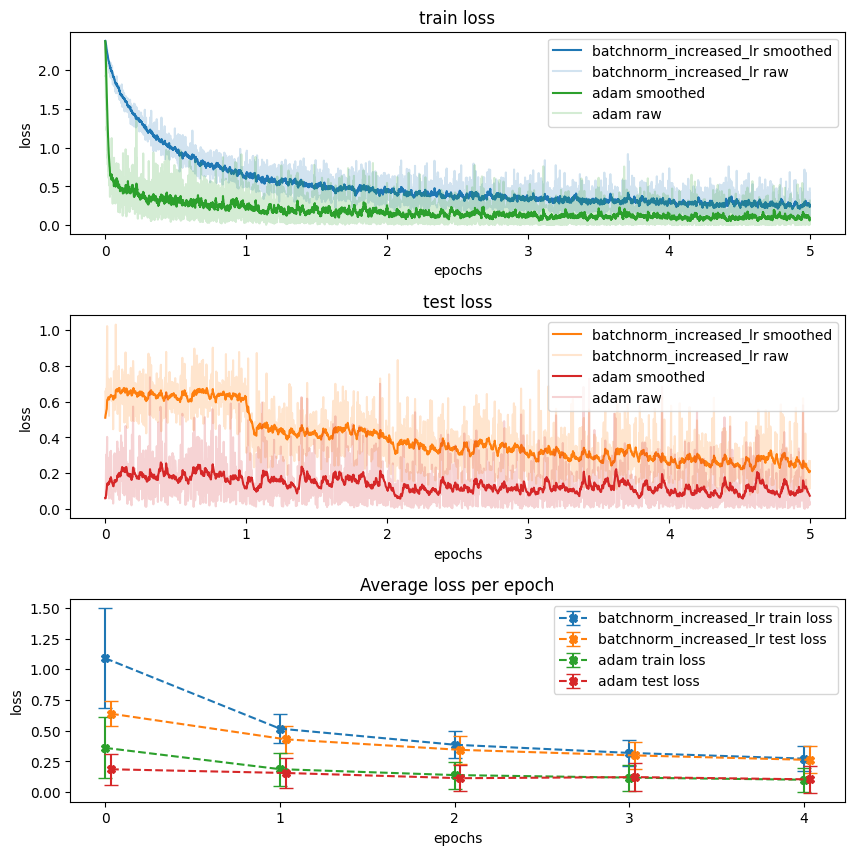

In [ ]:
history_plotter.plot(["batchnorm_increased_lr", model_name])

### L2 vs Weight decay

Для использования L2 c оптимизатором необходимо указать значение `weight_decay`,  где `weight_decay` — коэффициент перед L2.

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.RMSprop([parameters], alpha=0.99, weight_decay=0.001)

Вообще говоря, **Weight decay** и **L2** — это немного разные вещи.

**L2** добавляет член регуляризации к Loss функции:

$$\text{Loss}_{L2} = \text{Loss} + \frac{λ}{2n}w^2$$

**Weight decay** уменьшает веса:

$$w_{wd} = w - \frac{λ}{n}w$$

где $λ$ — константа, а $n$ — количество элементов в батче.


Для **SGD** оптимизатора **Weight decay** и **L2** **эквивалентны**, но не для всех оптимизаторов это так.

Например, это не так для **Adam**. **L2**-регуляризация прибавляется к Loss функции и изменяет **значение градиента**, квадраты которого будут храниться. **Weight decay** изменяет только веса. Подробно об этом можно почитать в:

[[arxiv] 🎓 Decoupled Weight Decay Regularization (Loshchilov, Hutter, 2019)](https://arxiv.org/pdf/1711.05101.pdf)

**Обратите внимание**, что `weight_decay` в `torch.optim.Adam` — это **коэффициент перед L2**. **Weight decay** для **Adam** реализовано в
`torch.optim.AdamW`.


### Другие оптимизаторы (Lion)

Есть альтернативные методы оптимизации, например, проект [Google Brain ✏️[blog]](https://research.google/teams/brain/) в 2023 году опубликовал [статью 🎓[arxiv]](https://arxiv.org/pdf/2302.06675.pdf), в которой описывает найденный в процессе [AutoML 🎓[arxiv]](https://arxiv.org/pdf/2101.08809.pdf) (автоматического подбора архитектур и алгоритмов) оптимизатор, названный **Lion**  (Evo**L**ved S**i**gn M**o**me**n**tum).

Интересно, что AutoML алгоритм пришел к интуитивно понятной эвристике: градиенты — вещь не очень надежная. Они могут взрываться и затухать. Может, тогда мы зафиксируем размер шага, а градиенты будем использовать только для определения направления?

Для определения направления используют функцию $\text{sign}$ (знак):

\begin{align}
\text{sign}(x) = \left\{
\begin{array}{cl}
1 & x > 0 \\
0 & x = 0\\
-1 & x < 0.
\end{array}
\right.
\end{align}


К этому добавляется уже изученный нами momentum, чтобы знак “прыгал” реже. Интересно, что AutoML подобрал алгоритм, в котором используются две константы для momentum. $\beta_1$ — для определения текущего знака градиента, $\beta_2$ — для хранения значения $v_t$. Значения по умолчанию $\beta_1 = 0.9$, $\beta_2 = 0.99$. Это значит, что текущее значение градиента сильнее влияет на значение для выбора направления текущего шага $c_{t}$, чем на хранимое значение момента $v_t$.


Значение для вычисления направления текущего шага:

$$c_{t} = \beta_1 \cdot v_{t-1} + (1-\beta_1) \nabla_wL(x, y, w_{t})$$

Шаг оптимизатора. $λ$ — константа weight decay:

$$w_{t+1} = w_t - \text{lr} \cdot (\text{sign}(c_t) +λ w_t)$$

Обновление хранимого значения момента:

$$v_t = \beta_2 \cdot v_{t-1} + (1-\beta_2) \nabla_wL(x, y, w_{t})$$

Фрагмент кода для понимания работы **Lion**:

```python
class Lion:
  def __init__(self, parameters, lr=0.0001, betas=(0.9, 0.99), weight_decay=0.01):
    self.parameters = parameters
    self.lr = lr
    self.betas = betas
    self.velocity = torch.zeros_like(parameters)
    self.beta_1 = betas[0] # momentum 1
    self.beta_2 = betas[1] # momentum 2
    self.weight_decay = weight_decay

  def step(self):
    d_parameters = self.parameters.grad
    # current momentum
    current = self.beta_1*self.velocity + (1 - self.beta_1)*d_parameters
    # step
    self.parameters -= self.lr*(torch.sign(carent)+self.weight_decay*self.parameters)
    # history momentum
    self.velocity = self.beta_2*self.velocity + (1 - self.beta_2)*d_parameters
```

**Lion удваивает количество хранимых параметров.**

Обратите внимание, что значение lr по умолчанию у **Lion** выбрано меньше, чем у **Adam**. Это связано с тем, что только lr и регуляризация определяют размер шага. Авторы статьи советуют брать для **Lion** в 10 раз меньший lr, чем для **Adam**.

У **Lion** есть преимущества по сравнению с **Adam** и **AdamW**: в нем нет необходимости хранить квадраты градиентов. Он позволяет **снизить количество хранимых параметров** в 1.5–2 раза по сравнению с **AdamW**, а также сокращает количество операций, что позволяет [ускорить расчеты на 2–15% 🎓[arxiv]](https://arxiv.org/pdf/2302.06675.pdf) (в Colab это незаметно из-за специфики, связанной с виртуальными машинами).

Кроме того, **Lion** [позволяет добиться лучших результатов 🐾[git]](https://github.com/google/automl/tree/master/lion), чем AdamW, при обучении больших сложных моделей, таких как Visual Transformer-ы и диффузионные модели.

Но до сложных моделей мы пока не добрались, попробуем простую. Воспользуемся реализацией [Lion-Pytorch 🐾[git]](https://github.com/lucidrains/lion-pytorch):

In [ ]:
!pip install -q lion-pytorch

In [ ]:
from lion_pytorch import Lion

model_name = "lion"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(
    model=model,
    exp_name=model_name,
    optimizer_class=Lion,
    optimizer_kwargs={"lr": 1e-4, "weight_decay": 1e-3},
)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


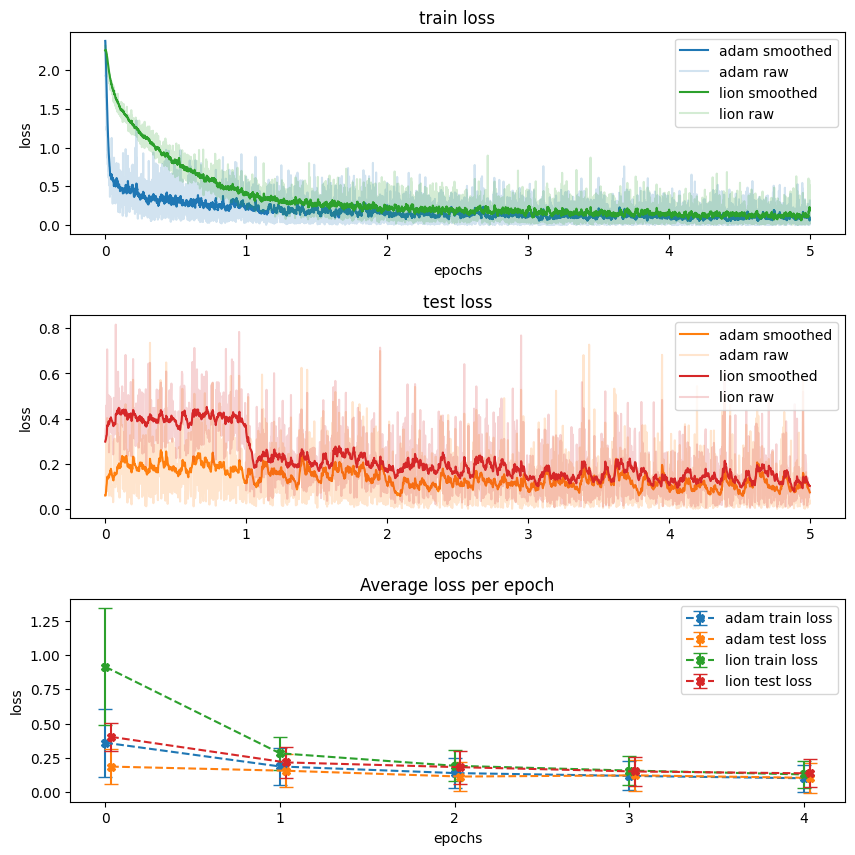

In [ ]:
history_plotter.plot(["adam", model_name])

Результат получился почти как у **Adam**, число хранимых параметров меньше. Для лучшего качества с Lion рекомендуется использовать `lr_scheduler`, чтобы постепенно понижать скорость обучения.



## Ландшафт функции потерь


Существует [исследование 🎓[article]](https://proceedings.neurips.cc/paper/2018/file/be3087e74e9100d4bc4c6268cdbe8456-Paper.pdf), которое показывает, что ландшафт функции потерь представляет собой не изолированные локальные минимумы (рисунок слева), а связанные области с почти постоянным значением (рисунок справа). Поэтому умение “выбираться” из седловых точек важно.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/loss_surfaces.png" width="900"></center>

<center><em>Source: <a href="https://proceedings.neurips.cc/paper/2018/file/be3087e74e9100d4bc4c6268cdbe8456-Paper.pdf">Loss Surfaces, Mode Connectivity, and Fast Ensembling of DNNs</a></em></center>

## Сравнение оптимизаторов

У каждого из предложенных оптимизаторов есть минусы и плюсы:

* Методы с инерцией сходятся к решению более плавно, но могут "перелетать".
* Методы с адаптивным learning rate быстрее сходятся, более стабильны и меньше случайно блуждают.
* Алгоритмы без адаптивного learning rate сложнее выбираются из локальных минимумов.
* Алгоритмы с инерцией осцилируют в седловых точках прежде, чем находят верный путь.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/methods_without_adaptive_learning_rate.gif" width="450"><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/methods_with_momentum_in_saddle_point.gif" width="450">

<em>Source: <a href="https://imgur.com/a/Hqolp">Visualizing Optimization Algos</a></em></center>